# Normalizing flows

Normalizing flows are a type of generative models that can learn parameteric distributions $p_\theta(x)$ from samples of the data distribution, $X$. The model can be used to both generate new samples $X$ from $p(x)$, and evaluate densities $p(x)$. See [this blogpost](https://lilianweng.github.io/posts/2018-10-13-flow-models/) for an in depth introduction to normalizing flows.

## Change of Variables in Probability Distributions

Normalizing flows are based on invertible functions $f$ that map the data, $x$, into a latent variable, $z$, $z=f(x)$. As we will see, in order to be able to both sample and evaluate densities the function $f$ must be invertible, and therefore $x$ and $z$ must be of the same dimensionality. If we choose $z$ to have a known density, $p(z)$, we can compute $p(x)$ from $p(z)$ as follows 

$ \int p_x(x) d x = \int p_z(z) d z$ = 1,

and therefore

$p_x(x) = p_z(z) \left \lvert \frac{dz}{dx} \right \rvert = p_z(f(x)) \left \lvert \frac{d f(x)}{dx} \right \rvert  $


This is known as change of variables in probability distributions. 

Let's first demonstrate the idea with a one dimensional example. We'll start sampling a random variable $Z$ from a gaussian distribution, $p(z)$, and transform it into a lognormal random variable $X$ with distribution, $p(x)$, using the inverse of $z=f(x)$. 

Let's write some code to see how to implement such a transformation to generate data from a lognormal distribution starting from a gaussian distribution

$z = \log(x), x = \exp(z)$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


In [2]:
def f(x):
    # Maps x to z
    return np.log(x)

def f_inverse(z):
    # Maps z to x
    return np.exp(z)

def jacobian_f(x):
    return 1/x



In [3]:
# z is sampled from a normal distribution
z = norm.rvs(size=5_000) 
# which we can easily evalate the density for
pz = norm.pdf(z)

In [4]:
# Now we can apply the transformation to generate samples from x
x = f_inverse(z)

# and evaluate the density on a grid, starting fromt he density of pz
x_grid = np.linspace(0.01,10,100)
px = norm.pdf(f(x_grid)) * jacobian_f(x_grid)

(0.0, 10.0)

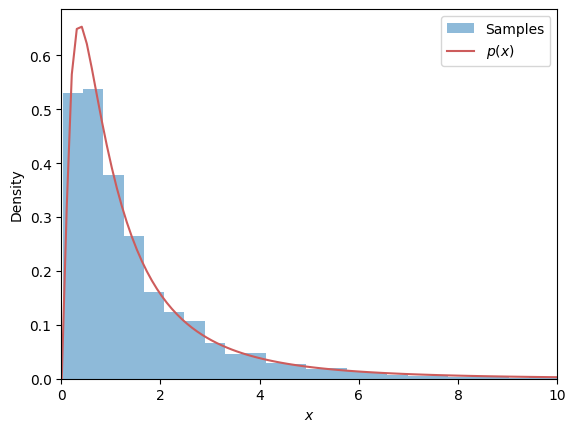

In [5]:

# The distribution is lognormal as expected
_ = plt.hist(x, density=True, bins=100, alpha=0.5, label='Samples')
plt.plot(x_grid,px, color='indianred', label=r'$p(x)$')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel('Density')
plt.xlim(0,10)

So we have used:
- $f^{-1}$ to sample from the data distribution $x$ by sampling from a gaussian, $z$
- $f$ to evaluate the density of the data distribution $x$

Now we will show how we can parametrize $f$ with a neural network that has some free parameters, $\theta$, which are then optimised on a training set by maximizing the likelihood of the training samples $p_\theta(x)$. You can see a summary of the model in the figure below.

<img src="../images/flows_schematic.png" width="800">

We will generate two-dimensional samples from the two-moon dataset

In [6]:
from sklearn import datasets, preprocessing
noise = 0.05
x, _ = datasets.make_moons(n_samples=10_000, noise=noise)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
n_features = x.shape[-1]

def sample_moons(n_samples=1000, noise=noise):
    x, _ = datasets.make_moons(n_samples=n_samples, noise=noise)
    return torch.Tensor(scaler.transform(x).astype(np.float32))

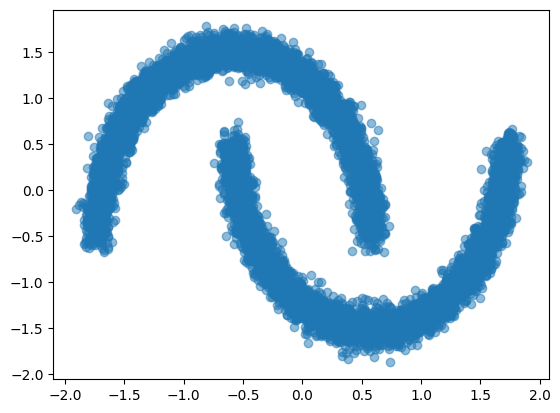

In [7]:
plt.scatter(x[:,0], x[:,1],alpha=0.5)

Now we need to build an invertible neural network to parametrize $f$, that also has a tractable jacobian such that we can train the neural network to maximize the likelihood of the data $p(x)$. Most neural network architectures are however not invertible (think about multilayer perceptrons or convolutional neural networks). Here, we will implement one of the simplest normalizing flow transformations known as Real NVP (See the original paper [here](https://arxiv.org/pdf/1605.08803v3.pdf))

In particular, computing determinants of high dimensional matrices is very expensive, which will be an issue for the calculation of the Jacobian's determinant. The basic idea of Real NVP is to simplify the determinant calculation by using a triangular matrix, whose determinant is simply the product of its diagonal terms. The transformation is defined as follows:

$$ 
y_{1:d} = x_{1:d}
$$
$$
y_{d+1:D} = x_{d+1:D} \odot \exp\left(s(x_{1:d}) \right) + t(x_{1:d})
$$
where $s$ and $t$ stand for scale and translation and are arbitrary functions, that we will define as neural networks, that map from $R^d \rightarrow R^{D-d}$ and $\odot$ is the element-wise product. This layer will be denoted as an affine coupling layer.

Computing the inverse is simple
$$
x_{1:d} = y_{1:d} 
$$
$$
x_{d+1:D} = \left( y_{d+1:D} - t(y_{1:d})\right) \odot \exp(-s(y_{1:d})) 
$$
And the jacobian is then given by

$$
\frac{\partial y}{\partial x^T} = \begin{bmatrix}
    \mathbb{I}_d & 0 \\
    \frac{\partial y_{d+1:D}}{\partial x^T_{1:d}} & \text{diag}\left( \exp[s(x_{1:d})]\right) 
\end{bmatrix} 
$$

Now this Jacobian is triangular, and therefore we can compute its determinant very efficiently as

$$
\left \lvert \frac{\partial y}{\partial x^T}  \right \rvert = \exp \left[ \sum_j s(x_{1:d})_j \right]
$$

and because computing this Jacobian doesn't involve derivatives of $s$ or $t$, this can be arbitrarily complex functions. If we stack several of these affine coupling layers, with varying splits $d$, we can get a powerful generative model.

In [8]:
import torch
from torch import nn, Tensor
from typing import Callable, List, Tuple

# Let's write down an affine coupling layer as a pytorch module for our two dimensional example
class AffineCoupling(nn.Module):
    def __init__(self, mask, scale: Callable, translation: Callable, ):
        """ affine coupling layer 

        Args:
            d (int): dimension in which to split the transform (x_d)
            scale (Callable): function that takes x_d as input and returns the scale s 
            translation (Callable): function that takes x_d as input and returns the translation t 
            flip (bool): whether to flip the dimension in d that is being transformed 
        """
        super().__init__()
        self.mask = mask
        self.idx_a = mask.nonzero().squeeze(-1)
        self.idx_b = (~mask).nonzero().squeeze(-1)
        self.scale = scale
        self.translation = translation

    def split(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        return x[..., self.idx_a], x[..., self.idx_b]

    def merge(self, x_a: Tensor, x_b: Tensor, shape: Tuple) -> Tensor:
        x = x_a.new_empty(shape)
        x[..., self.idx_a] = x_a
        x[..., self.idx_b] = x_b
        return x

    def get_scale_and_shift(self, x: torch.Tensor,)->torch.Tensor:
        scale = self.scale(x)
        shift = self.translation(x)
        return scale, shift

    def forward(self, x: torch.Tensor)->torch.Tensor:
        """ applies the coupling transform $y = f(x)$ 

        Args:
            x (torch.Tensor): tensor to transformed 

        Returns:
            torch.Tensor: transformed tensor 
        """
        x_a, x_b = self.split(x)
        scale, shift = self.get_scale_and_shift(x_a)
        y_b = torch.exp(scale) * x_b + shift
        return self.merge(x_a, y_b, x.shape)

    def inverse(self, y: torch.Tensor)->torch.Tensor:
        """ inverse of the coupling transform, $x = f^{-1}(y)$

        Args:
            y (torch.Tensor): tensor to inverse transform 

        Returns:
            torch.Tensor: inverse transformed tensor 
        """
        y_a, y_b = self.split(y)
        scale, shift = self.get_scale_and_shift(y_a)
        x_b = (y_b - shift) * torch.exp(-scale)
        return self.merge(y_a, x_b, y.shape)

    def log_abs_det_jacobian(self, x: torch.Tensor)->torch.Tensor:
        """ Jacobian log determinant

        Args:
            x (torch.Tensor): input tensor 

        Returns:
            torch.Tensor: log jacobian of the transformation 
        """
        x_a, _ = self.split(x)
        log_det = self.scale(x_a)
        return -torch.sum(log_det, dim=-1)


# Let's now create a coupling layer given some randomly initialized neural networks for the scale and translation
def create_coupling_layer(mask, hidden_dim=256):
    # note that because exponentials of the scale are involved using a tanh for the scale network is a good idea to keep things under control
    scale = nn.Sequential(
        nn.Linear(1, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, 1), 
        nn.Tanh()
    )
    translation = nn.Sequential(
        nn.Linear(1, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, 1),
    )
    return AffineCoupling(mask=mask,scale=scale, translation=translation)


In [9]:
coupling = create_coupling_layer(torch.tensor([0.,1.],dtype=torch.bool))


In [10]:
# try with same scale and shift in both models, why is it not working inverse exact?

In [11]:

# let's check that the inverse transform is exactly the same
inputs = torch.randn(3,2)

print(inputs)
print(coupling.inverse(coupling.forward(inputs)).detach())

tensor([[ 0.1805, -0.3333],
        [ 1.3183, -0.6186],
        [ 0.2324, -0.7246]])
tensor([[ 0.1805, -0.3333],
        [ 1.3183, -0.6186],
        [ 0.2324, -0.7246]])


In [12]:
# and that we can compute the jacobian
coupling.log_abs_det_jacobian(inputs)

tensor([-0.0972, -0.0705, -0.0560], grad_fn=<NegBackward0>)

Now we'll chain some of this layers into one model

In [13]:
class RealNVP(nn.Module):
    def __init__(self, coupling_layers: List[AffineCoupling], base_distribution: "torch.distribution",):
        """ RealNVP normalizing flow

        Args:
            coupling_layers (List[AffineCoupling]): list of coupling layers 
            base_distribution (torch.distribution): base distribution to define the flow 
        """
        super().__init__()
        self.coupling_layers = nn.ModuleList(coupling_layers)
        self.base_distribution = base_distribution 

    def forward(self, z: torch.Tensor)->torch.Tensor:
        """ apply the stacked transformations

        Args:
            z (torch.Tensor): input tensor 

        Returns:
            torch.Tensor: transformed tensor 
        """
        for layer in self.coupling_layers:
            z = layer(z)
        return z
    
    def inverse(self, x: torch.Tensor)->torch.Tensor:
        """ apply the inverse stacked transformations

        Args:
            x (torch.Tensor): tensor to inverse transform 

        Returns:
            torch.Tensor: inverse transformed tensor 
        """
        for layer in reversed(self.coupling_layers):
            x = layer.inverse(x)
        return x

    def log_prob(self, x: torch.Tensor)->torch.Tensor:
        """ Compute px from pz

        Args:
            x (torch.Tensor): to evaluate the density of 

        Returns:
            torch.Tensor: p(x) 
        """
        log_jacobian = 0 
        for layer in reversed(self.coupling_layers):
            log_jacobian += layer.log_abs_det_jacobian(x)
            x = layer.inverse(x)
        pz = self.base_distribution.log_prob(x)
        return pz + log_jacobian

    def sample(self, n_samples: int)->torch.Tensor:
        """ generate samples from p(x)

        Args:
            n_samples (int): number of samples to generate 

        Returns:
            torch.Tensor: samples from p(x) 
        """
        z = self.base_distribution.sample((n_samples,))
        return self.forward(z)

In [14]:
n_transforms = 10
coupling_layers = []
for i in range(n_transforms):
    mask = [True, False] if i % 2 == 0 else [False, True]
    mask = torch.tensor(mask, dtype=torch.bool)
    coupling_layers.append(create_coupling_layer(mask=mask))
flow = RealNVP(
    coupling_layers,
    base_distribution = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
)

iter 0: loss = 3.183


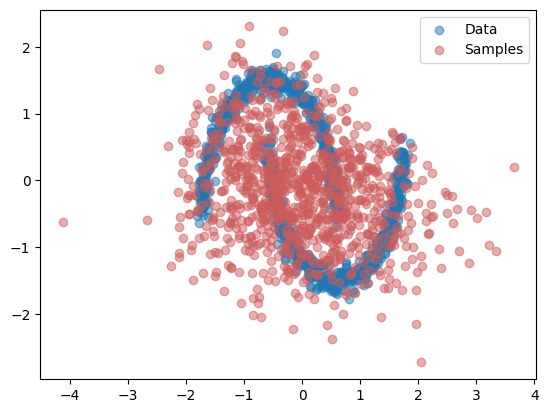

iter 500: loss = 1.417


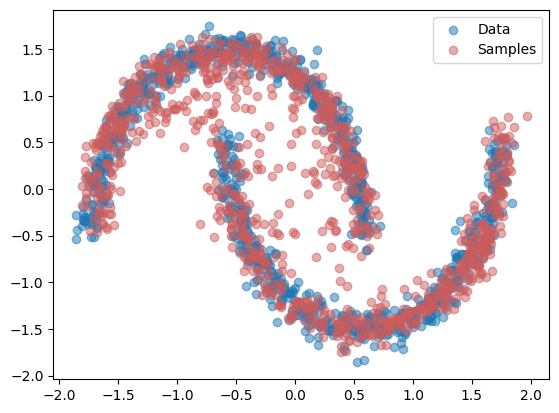

iter 1000: loss = 1.331


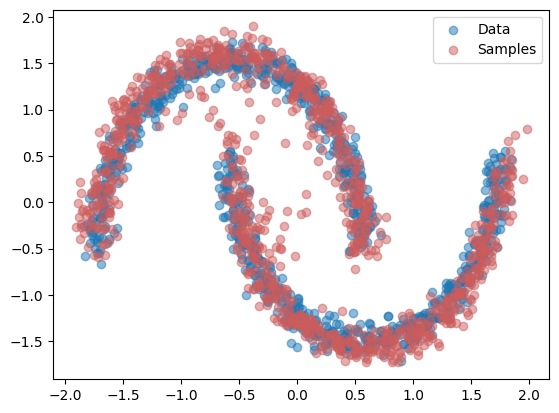

iter 1500: loss = 1.319


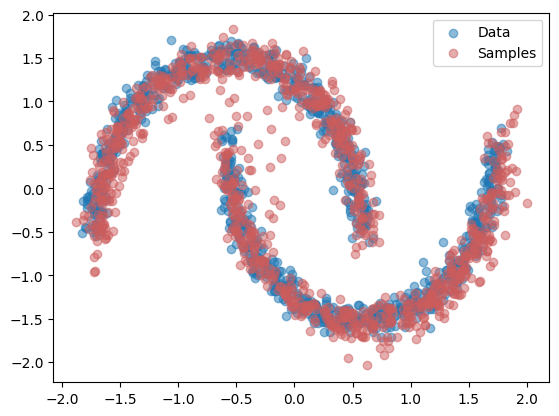

In [15]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
n_batch = 100 
for t in range(10_000):
    noisy_moons = sample_moons(n_samples=n_batch, noise=noise)
    loss = -flow.log_prob(noisy_moons).mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        sampled_moons = flow.sample(1000).detach().numpy()
        noisy_moons = sample_moons(n_samples=1000, noise=noise)
        plt.scatter(noisy_moons[:,0], noisy_moons[:,1],alpha=0.5, label='Data')
        plt.scatter(sampled_moons[:,0], sampled_moons[:,1],alpha=0.5, color='indianred', label='Samples')
        plt.legend()
        plt.show()

In [ ]:
sampled_moons = flow.sample(100_000).detach().numpy()
noisy_moons = sample_moons(n_samples=1000, noise=noise)

(-2.0, 2.0)

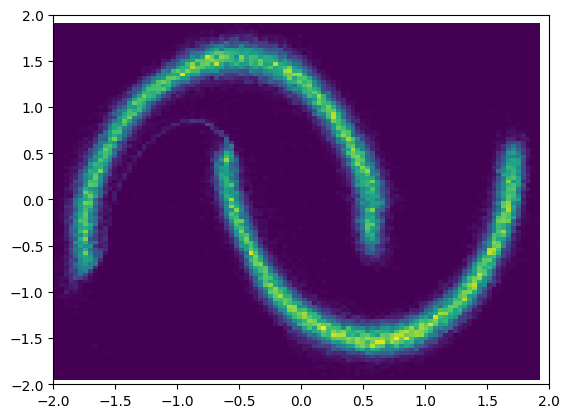

In [ ]:
_ = plt.hist2d(sampled_moons[:, 0], sampled_moons[:, 1], bins=100,)
plt.xlim(-2, 2)
plt.ylim(-2, 2)


In [ ]:
# Let's look at how the density of the data is transformed by the flow
z = flow.base_distribution.sample((1000,))
z_layers = [z]
for layer in flow.coupling_layers:
    z = layer(z)
    z_layers.append(z)

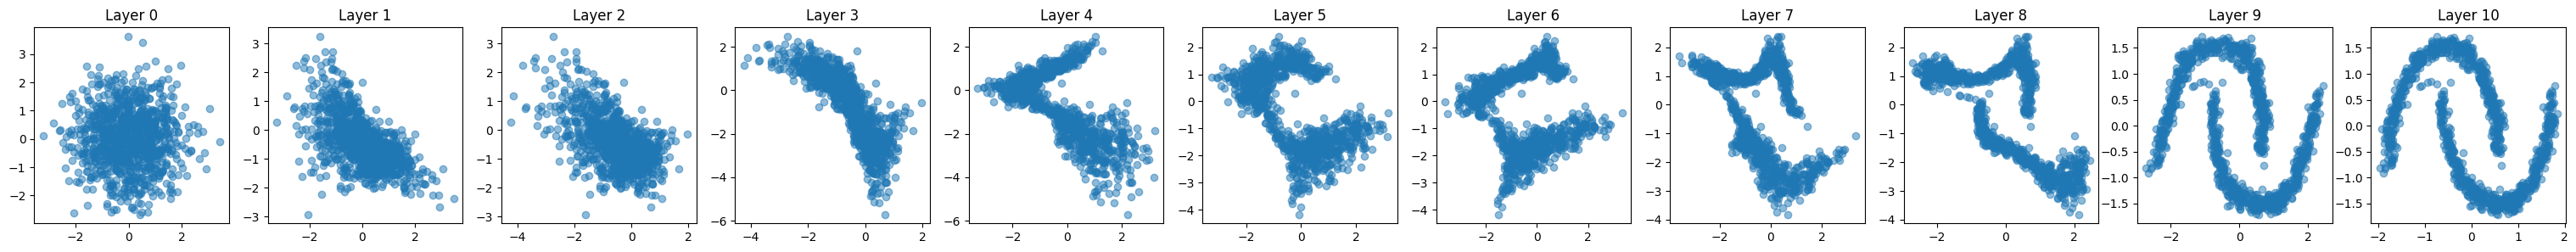

In [ ]:
fig, ax = plt.subplots(ncols=len(flow.coupling_layers)+1, figsize=((len(flow.coupling_layers)+1)*3.5, 3))
for layer in range(len(flow.coupling_layers)+1):
    z_layer = z_layers[layer].detach().numpy()
    ax[layer].scatter(z_layer[:,0], z_layer[:,1],alpha=0.5)
    ax[layer].set_title(f'Layer {layer}')

In [ ]:
# Let's look at how the density of the data is transformed by the flow
z = flow.sample(1000)
z_layers = [z]
for layer in flow.coupling_layers[::-1]:
    z = layer.inverse(z)
    z_layers.append(z)

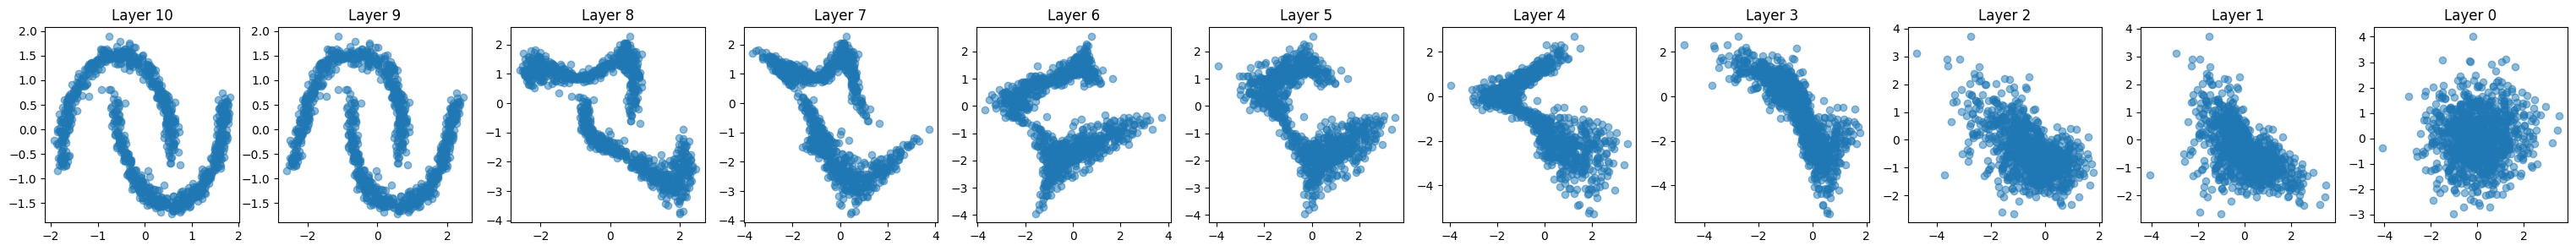

In [ ]:
fig, ax = plt.subplots(ncols=len(flow.coupling_layers)+1, figsize=((len(flow.coupling_layers)+1)*3.5, 3))
for layer in range(len(flow.coupling_layers)+1):
    z_layer = z_layers[layer].detach().numpy()
    ax[layer].scatter(z_layer[:,0], z_layer[:,1],alpha=0.5)
    ax[layer].set_title(f'Layer {len(flow.coupling_layers) - layer}')